## <ins>**CSEN 140 Final Project**</ins> 
Tiffany Nguyen and Lindsey Leong

12/13/24

### **Project Overview:**
**Purpose:** 

Our project will receive images of musculoskeletal x-rays from the MURA dataset and classify those images into either positive or negative for having a musculoskeletal abnormality. 

**Steps:**
1. Read images from MURA Dataset
2. Preprocessing images
3. Training / Evaluating models
4. Visualize results

### **Variable Guide**:
**Variables for preprocessing**
- TARGET_SIZE: size after adding padding to original images (set to max image width/height in dataset = 512)
- RESIZED_SIZE: size after resizing padded image
- IMG_COUNT_TRAIN: number of elements per category for training set
- IMG_COUNT_VALID: number of elements per category for validation set

**Image divided by category:**
- (train/valid)_category_images: dictionary where key is category string and value is array of images in that category for training
- (train/valid)_category_labels: dictionary where key is category string and value is array of labels (0 or 1) in that category for training

**Final Variables to use in future steps**
- train_images: all images from all categories for training
- train_labels: all labels for training images
- valid_images: all images from all categories for validation
- valid_labels: all labels for validation images

## <ins>**Step 1: Read Images from MURA Dataset**</ins>
a. import libraries 

b. Read image path CSV files 
    
c. Run load_images function for both train and valid data

### **1a) import libraries**

In [1]:
# import libraries
import pandas as pd
import os
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

### **1b) Read image path CSV files**
- training data (trainimage_paths.csv)
- validation data (valid_image_paths.csv)

In [2]:
# Read train image paths CSV file
train_csv_file = 'MURA-v1.1/train_image_paths.csv' 
train_paths_df = pd.read_csv(train_csv_file, header=None, names=['image_path'])
train_paths_df

,image_path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
...,...
36803,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
36804,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
36805,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...
36806,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...


In [3]:
# Read valid image paths CSV file
valid_csv_file = 'MURA-v1.1/valid_image_paths.csv' 
valid_paths_df = pd.read_csv(valid_csv_file, header=None, names=['image_path'])
valid_paths_df

,image_path
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...
...,...
3192,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...
3193,MURA-v1.1/valid/XR_FINGER/patient11967/study1_...
3194,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...
3195,MURA-v1.1/valid/XR_FINGER/patient11738/study1_...


### **1c) Run load_images_labels function for both train/valid data**
the following variables are initiated:
- (train/valid)_images
- (train/valid)_labels
- (train/valid)_category_images
- (train/valid)_category_labels

**File loading functions**
- process_image: gets an image from its file path
- read_images: processes a list of images from a list of file paths
- load_images_labels: creates a dictionary of images/labels based on their body part category
- combine_category: combines dictionaries of images/labels into one array

In [4]:
CATEGORIES = ['XR_SHOULDER', 'XR_WRIST', 'XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS']

# Function to read and process iamge
TARGET_SIZE = 512
RESIZED_SIZE = 90
IMAGE_COUNT_TRAIN = 1000
IMAGE_COUNT_VALID = 1000

def process_image(image_path):
    image = Image.open(image_path) # read image

    # Add padding to image
    original_width, original_height = image.size
    new_image = Image.new('L', (TARGET_SIZE, TARGET_SIZE), 0)  # black background of target size
    paste_x = (TARGET_SIZE - original_width) // 2
    paste_y = (TARGET_SIZE - original_height) // 2
    new_image.paste(image, (paste_x, paste_y))

    # Resize image for efficiency
    resized_image = new_image.resize((RESIZED_SIZE, RESIZED_SIZE))
    
    return np.array(resized_image)

# Function to read all images in a category
def read_images(paths_df, category, image_count):
    category_images = {category: [] for category in CATEGORIES}
    category_labels = {category: [] for category in CATEGORIES}
    filtered_df = paths_df[paths_df['image_path'].str.contains(f'/{category}/')].head(image_count)
    for path in filtered_df['image_path']:
        try:
            category_images[category].append(process_image(path)) # Process and append image
            label = 1 if 'positive' in path else 0 # Determine and append label (1 for positive, 0 for negative)
            category_labels[category].append(label)
        except FileNotFoundError:
            print(f"Image not found: {path}")
    return category_images, category_labels

def combine_category(category):
    # Combine all body part categories values into 1 array
    combined_category = np.concatenate([category['XR_ELBOW'], 
                                category['XR_FINGER'], 
                                category['XR_FOREARM'],
                                category['XR_HAND'],
                                category['XR_HUMERUS'],
                                category['XR_SHOULDER'],
                                category['XR_WRIST']], axis=0)
    print("Shape:", combined_category.shape)
    return combined_category

# Loop through each category and process images
def load_images_labels(paths_df, image_count):
    all_category_images = {}
    all_category_labels = {}
    for category in CATEGORIES:
        print(f"Reading category: {category}", end="\t| ")
        # read image paths into images and labels
        category_images, category_labels = read_images(paths_df, category, IMAGE_COUNT_TRAIN)

        # Convert lists to numpy arrays and add to category_images
        all_category_images[category] = np.array(category_images[category])
        all_category_labels[category] = np.array(category_labels[category])

        # Print Result 
        print(f"Loaded {len(all_category_images[category])} images from {category} folder.", end="\t| ")
        print(f"Labels for {category} length: {len(all_category_labels[category])}")

    return all_category_images, all_category_labels

**Plot images function**

In [5]:
def plot_images(images, labels, category_images, category_labels, choice_image_num, SEED):
    rng = np.random.default_rng(SEED) # random number generator

    plt.figure()
    PIC_Y = 2 # number of pictures in columns
    PIC_X = 4 # number of pictures in rows

    #subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(PIC_Y, PIC_X, figsize=(10, 6)) 
    f.suptitle("X-Rays (Processed)")

    # print a random picture for each category
    x = 0
    y = 0
    for body_part in CATEGORIES:
        if y >= PIC_Y:
            y = 0
        if x >= PIC_X:
            x = 0
            y += 1
        image_num = rng.integers(low=0, high=len(category_images[body_part])) # random image number within body part range
        axarr[y][x].imshow(category_images[body_part][image_num], cmap="gray")
        axarr[y][x].set_xlabel("result = " + str(labels[image_num]))
        axarr[y][x].tick_params(left = False, bottom = False, labelbottom=False, labelleft=False)
        axarr[y][x].set_title(body_part + " " + str(image_num))
        x += 1

        print(body_part, ":", images[image_num].shape, end=" | ")

    # print extra image of choice at index choice_image_num
    axarr[PIC_Y - 1][PIC_X - 1].imshow(images[choice_image_num], cmap="gray")
    axarr[y][x].set_xlabel("result = " + str(labels[choice_image_num]))
    axarr[y][x].tick_params(left = False, bottom = False, labelbottom=False, labelleft=False)
    axarr[PIC_Y - 1][PIC_X - 1].set_title("choice img " + str(choice_image_num))

**Run load_images_labels function on training paths dataframe**

In [6]:
# get get training images by category and training results by category
print("getting training image/labels by category...")
train_category_images, train_category_labels = load_images_labels(train_paths_df, IMAGE_COUNT_TRAIN)

print()

# combine category_images and category_labels
print("combining train images...")
train_images = combine_category(train_category_images)
print("combining train labels...")
train_labels = combine_category(train_category_labels)

getting training image/labels by category...
Reading category: XR_SHOULDER	| Loaded 1000 images from XR_SHOULDER folder.	| Labels for XR_SHOULDER length: 1000
Reading category: XR_WRIST	| Loaded 1000 images from XR_WRIST folder.	| Labels for XR_WRIST length: 1000
Reading category: XR_ELBOW	| Loaded 1000 images from XR_ELBOW folder.	| Labels for XR_ELBOW length: 1000
Reading category: XR_FINGER	| Loaded 1000 images from XR_FINGER folder.	| Labels for XR_FINGER length: 1000
Reading category: XR_FOREARM	| Loaded 1000 images from XR_FOREARM folder.	| Labels for XR_FOREARM length: 1000
Reading category: XR_HAND	| Loaded 1000 images from XR_HAND folder.	| Labels for XR_HAND length: 1000
Reading category: XR_HUMERUS	| Loaded 1000 images from XR_HUMERUS folder.	| Labels for XR_HUMERUS length: 1000

combining train images...
Shape: (7000, 90, 90)
combining train labels...
Shape: (7000,)


**Display training images**

XR_SHOULDER : (90, 90) | XR_WRIST : (90, 90) | XR_ELBOW : (90, 90) | XR_FINGER : (90, 90) | XR_FOREARM : (90, 90) | XR_HAND : (90, 90) | XR_HUMERUS : (90, 90) | 

<Figure size 640x480 with 0 Axes>

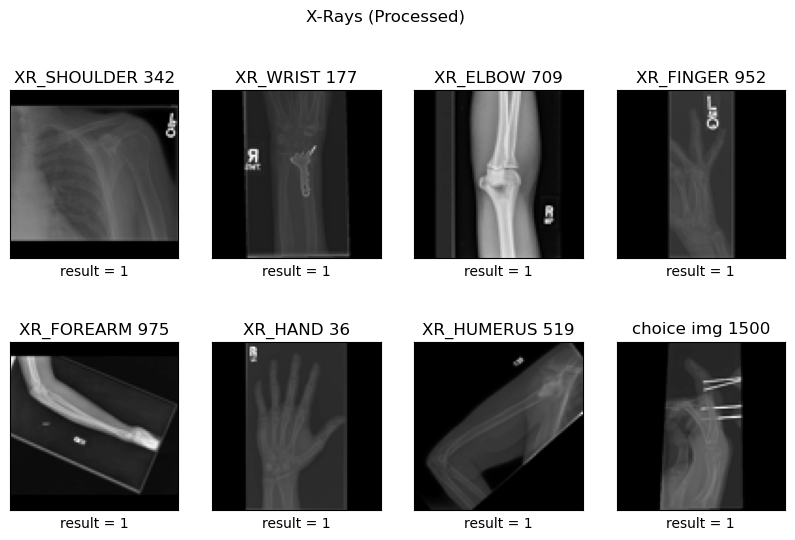

In [7]:
plot_images(train_images, train_labels, train_category_images, train_category_labels, 1500, 512)

**Run load_images_labels function on validation paths dataframe**

In [8]:
# get get training images by category and training results by category
print("getting validation image/labels by category...")
valid_category_images, valid_category_labels = load_images_labels(valid_paths_df, IMAGE_COUNT_TRAIN)

print()

# combine category_images and category_labels
print("combining validation images...")
valid_images = combine_category(valid_category_images)
print("combining validation labels...")
valid_labels = combine_category(valid_category_labels)

getting validation image/labels by category...
Reading category: XR_SHOULDER	| Loaded 563 images from XR_SHOULDER folder.	| Labels for XR_SHOULDER length: 563
Reading category: XR_WRIST	| Loaded 659 images from XR_WRIST folder.	| Labels for XR_WRIST length: 659
Reading category: XR_ELBOW	| Loaded 465 images from XR_ELBOW folder.	| Labels for XR_ELBOW length: 465
Reading category: XR_FINGER	| Loaded 461 images from XR_FINGER folder.	| Labels for XR_FINGER length: 461
Reading category: XR_FOREARM	| Loaded 301 images from XR_FOREARM folder.	| Labels for XR_FOREARM length: 301
Reading category: XR_HAND	| Loaded 460 images from XR_HAND folder.	| Labels for XR_HAND length: 460
Reading category: XR_HUMERUS	| Loaded 288 images from XR_HUMERUS folder.	| Labels for XR_HUMERUS length: 288

combining validation images...
Shape: (3197, 90, 90)
combining validation labels...
Shape: (3197,)


**Display validation images**

XR_SHOULDER : (90, 90) | XR_WRIST : (90, 90) | XR_ELBOW : (90, 90) | XR_FINGER : (90, 90) | XR_FOREARM : (90, 90) | XR_HAND : (90, 90) | XR_HUMERUS : (90, 90) | 

<Figure size 640x480 with 0 Axes>

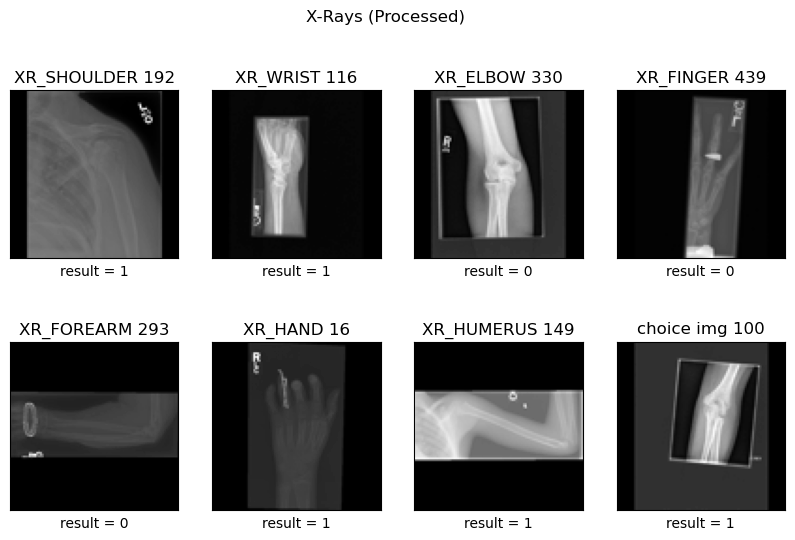

In [9]:
plot_images(valid_images, valid_labels, valid_category_images, valid_category_labels, 100, 512)

## <ins>**Step 2: Training and Evaluating Machine Learning Models**</ins>
**Preprocessing function:**
1. input: category_images, category_labels, list of processing methods
2. executes processing methods (in order of index) onto category images
3. output: processed category_images, processed category_labels

**Preprocessing methods:**
You can play with features. Use feature selection or feature extraction. 

a. apply PCA

- perform dimensional reduction on data (https://scikit-learn.org/1.5/auto_examples/applications/plot_digits_denoising.html)

b. filter functions

c. segmentation functions (detecting/removing backgrounds)

d. data augmentation functions

e. preprocessing application to dataset

### **2a) PCA: Dimensionality Reduction**
- source: https://www.geeksforgeeks.org/reduce-data-dimentionality-using-pca-python/

In [ ]:
from sklearn.decomposition import PCA, IncrementalPCA

def pca_compression(image):
    VARIANCE = 95 # ideally 1 < VARIANCE < 100
    new_image = image / image.max() # cap pixel values to 1 
    pca = PCA()
    pca.fit(new_image)
    cum_var = np.cumsum(pca.explained_variance_ratio_) * 100 # cumulative variance
    '''
    desired_components = np.argmax(cum_var > VARIANCE) # num PCs that explain VARIANCE% of variance
    print(desired_components, "components explain", VARIANCE, "% of total variance.")
    '''
    num_components = 10
    pca_inc = IncrementalPCA(n_components=num_components)
    new_image = pca_inc.inverse_transform(pca_inc.fit_transform(new_image))
    return new_image

### **2b) Filter Functions**
- normalize: improves contrast of image
- grayscale: turns all colors into black/white spectrum
- gaussian blur: blurs an image by smoothing out uneven pixel values
- median blur: removes noise from images by replacing each pixel with the median of its neighboring pixels
- laplacian filter: emphasizes edges by measuring how quickly first derivatives change
- unsharp masking: sharpens images by increasing contrast/reducing noise
- bilateral filter: edge-preserving, and noise-reducing smoothing filter that replaces the intensity of each pixel with a weighted average of intensity values from nearby pixels

In [11]:
from scipy import ndimage

# normalize: improves contrast of image
def filter_normalize(image):
    return cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# grayscale: turns all colors into black/white spectrum
def filter_grayscale(image):
    if len(image.shape) > 2:
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

# gaussian blur: blurs an image by smoothing out uneven pixel values
def filter_gaussian_blur(image):
    STRENGTH = 1 # increase this and things will slow down dramatically
    return ndimage.gaussian_filter(image, sigma=STRENGTH)

# median filter: removes noise from images by replacing each pixel with the median of its neighboring pixels
def filter_median(image):
    return cv2.medianBlur(image, 51)

# laplacian filter: emphasizes edges by measuring how quickly first derivatives change
def filter_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_16S, ksize=3)

# unsharp mask: sharpens images by increasing contrast/reducing noise
def filter_unsharp(image):
    IMAGE_STRENGTH = 3 # strength of image overlay
    GAUSS_IMAGE_STRENGTH = -2 # strength of gaussian image overlay
    gaussian_image = ndimage.gaussian_filter(image, sigma=10)
    return cv2.addWeighted(image, IMAGE_STRENGTH, gaussian_image, GAUSS_IMAGE_STRENGTH, 0)

# bilateral filter: edge-preserving, and noise-reducing smoothing filter that replaces the intensity of each pixel with a weighted average of intensity values from nearby pixels
def filter_bilateral(image):
    NEIGHBORHOOD_DIAMETER = 5 # increase this and things will slow down dramatically
    return cv2.bilateralFilter(image, NEIGHBORHOOD_DIAMETER, 255, 100) 

 

### **2c) Segmentation Functions**
- thresholding: converts color/grayscale image to binary image, selects areas of interest while ignoring less useful info
- edge detection: emphasizes the edges of images

note: region growing and watershed not implemented (due to requiring more individualistic implementations)

In [12]:
# threshold: converts color/grayscale image to binary image, selects areas of interest while ignoring less useful info
# THRESH_BINARY: pixel values below THRESH change to black, above THRESH change to NEW_PIXEL (255 = white)
# THRESH_BINARY_INV: pixel values below THRESH change to white, above THRESH change to black
# THRESH_TRUNC: pixel values above THRESH are set to NEW_PIXEL (the rest are unchanged)
# THRESH_TOZERO: pixel values below THRESH are set to NEW_PIXEL (the rest are unchanged)
# THRESH_TOZERO_INV: pixel values above THRESH are set to zero
def seg_threshold(image):
    THRESH = 35
    NEW_PIXEL = 255
    THRESH_TYPE = cv2.THRESH_BINARY
    ret, thresh_image = cv2.threshold(image, THRESH, NEW_PIXEL, cv2.THRESH_BINARY)
    return thresh_image

# edge detection: emphasizes the edges of images
def seg_edge_det(image):
    UPPER = 200 # pixel values above UPPER are considered strong edges
    LOWER = 100 # pixel values below LOWER are considered not edges
    return cv2.Canny(image, LOWER, UPPER)

### **2d) Data Augmentation Functions**
- flipping: flips image around horizontal/vertical axis
- rotating: rotates image by a certain amount of degrees

In [13]:
# flip: flips image around AXIS
def data_aug_flip_x(image):
    AXIS = 0 # 0 = flip around x-axis, 1 = flip around y-axis, -1 = flip around both axes
    return cv2.flip(image, AXIS)

def data_aug_flip_y(image):
    AXIS = 1 # 0 = flip around x-axis, 1 = flip around y-axis, -1 = flip around both axes
    return cv2.flip(image, AXIS)

# rotate: rotates image DEGREES degrees
def data_aug_rotate(image, degrees):
    height, width = image.shape
    image_rotated = ndimage.rotate(image, degrees)
    new_height, new_width = image_rotated.shape
    return image_rotated[new_height//2 - height//2:new_height//2 + height//2, new_width//2 - width//2:new_width//2 + width//2] # crop image to original size

def data_aug_rotate_neg30(image):
    return data_aug_rotate(image, -30)
def data_aug_rotate_neg15(image):
    return data_aug_rotate(image, -15)
def data_aug_rotate_pos30(image):
    return data_aug_rotate(image, 30)
def data_aug_rotate_pos15(image):
    return data_aug_rotate(image, 15)

### **2e) Preprocessing Function Application to Dataset**

In [14]:
# apply preprocessing methods to a single image
def preprocess(arr, image):
    for func in arr:
        image = func(image)
    return image

# apply preprocessing methods to a copy of a single image
def preprocess_copy(arr, image):
    image_copy = image.copy()
    for func in arr:
        image_copy = func(image_copy)
    return image_copy

# apply preprocessing methods to all images in a category_images dictionary
def preprocess_images(category_images, func_list):
    category_images_ppr = {category: [] for category in CATEGORIES}
    for category in CATEGORIES:
        category_images_singular_ppr = []
        for image in category_images[category]:
            image_copy = image.copy()
            category_images_singular_ppr.append(preprocess(func_list,image_copy))
        category_images_ppr[category] = category_images_singular_ppr
        print("done preprocessing:", category)
    return category_images_ppr

**Applying preprocessing methods to training images**

done preprocessing: XR_SHOULDER
done preprocessing: XR_WRIST
done preprocessing: XR_ELBOW
done preprocessing: XR_FINGER
done preprocessing: XR_FOREARM
done preprocessing: XR_HAND
done preprocessing: XR_HUMERUS
Shape: (7000, 90, 90)
train_images shape: (7000, 90, 90)
XR_SHOULDER : (90, 90) | XR_WRIST : (90, 90) | XR_ELBOW : (90, 90) | XR_FINGER : (90, 90) | XR_FOREARM : (90, 90) | XR_HAND : (90, 90) | XR_HUMERUS : (90, 90) | 

<Figure size 640x480 with 0 Axes>

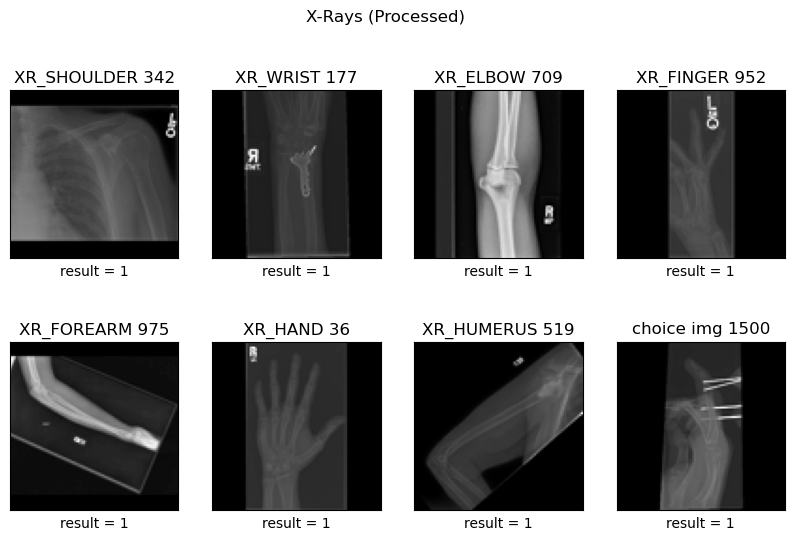

In [101]:
func_list = [filter_normalize] # preprocessing methods that are applied to each image

# apply preprocessing methods
train_category_images_ppr = preprocess_images(train_category_images, func_list)
train_images_ppr = combine_category(train_category_images_ppr)
print("train_images shape:", train_images_ppr.shape)

# plot images
plot_images(train_images_ppr, train_labels, train_category_images_ppr, train_category_labels, 1500, 512)

# doing the damage
# train_category_images = train_category_images_ppr
# train_images = train_images_ppr

**Apply Preprocessing to validation images**

done preprocessing: XR_SHOULDER
done preprocessing: XR_WRIST
done preprocessing: XR_ELBOW
done preprocessing: XR_FINGER
done preprocessing: XR_FOREARM
done preprocessing: XR_HAND
done preprocessing: XR_HUMERUS
Shape: (3197, 90, 90)
valid_images shape: (3197, 90, 90)
XR_SHOULDER : (90, 90) | XR_WRIST : (90, 90) | XR_ELBOW : (90, 90) | XR_FINGER : (90, 90) | XR_FOREARM : (90, 90) | XR_HAND : (90, 90) | XR_HUMERUS : (90, 90) | 

<Figure size 640x480 with 0 Axes>

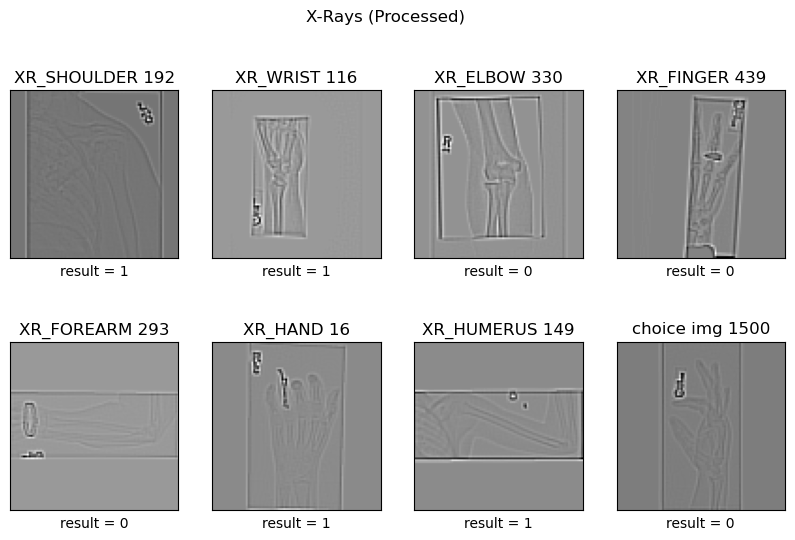

In [16]:
# apply preprocessing methods
valid_category_images_ppr = preprocess_images(valid_category_images, func_list)
valid_images_ppr = combine_category(valid_category_images_ppr)
print("valid_images shape:", valid_images_ppr.shape)

# plot images
plot_images(valid_images_ppr, valid_labels, valid_category_images_ppr, valid_category_labels, 1500, 512)

# doing the damage
# valid_category_images = valid_category_images_ppr
# valid_images = valid_images_ppr

**Applying preprocessing methods to validation images**

done preprocessing: XR_SHOULDER
done preprocessing: XR_WRIST
done preprocessing: XR_ELBOW
done preprocessing: XR_FINGER
done preprocessing: XR_FOREARM
done preprocessing: XR_HAND
done preprocessing: XR_HUMERUS
Shape: (3197, 90, 90)
valid_images shape: (3197, 90, 90)
XR_SHOULDER : (90, 90) | XR_WRIST : (90, 90) | XR_ELBOW : (90, 90) | XR_FINGER : (90, 90) | XR_FOREARM : (90, 90) | XR_HAND : (90, 90) | XR_HUMERUS : (90, 90) | 

<Figure size 640x480 with 0 Axes>

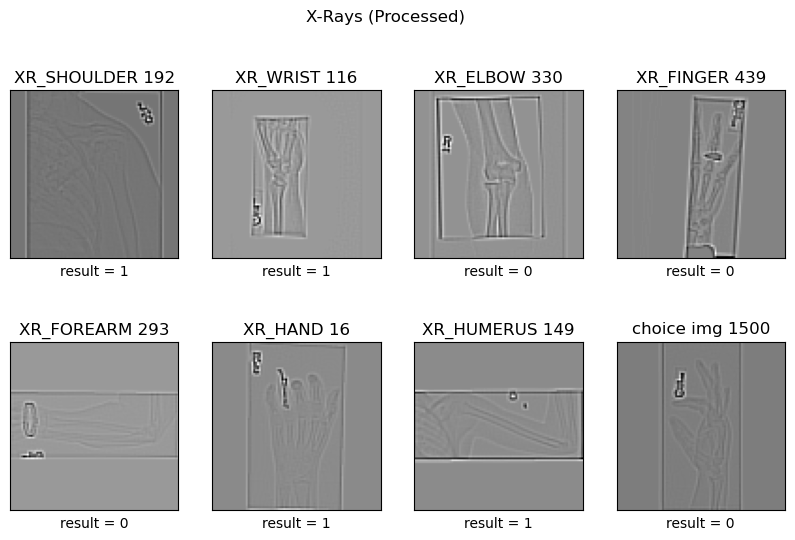

In [17]:
func_list = [filter_grayscale, filter_unsharp, filter_laplacian] # preprocessing methods that are applied to each image

# apply preprocessing methods
valid_category_images_ppr = preprocess_images(valid_category_images, func_list)
valid_images_ppr = combine_category(valid_category_images_ppr)
print("valid_images shape:", valid_images_ppr.shape)

# plot images
plot_images(valid_images_ppr, valid_labels, valid_category_images_ppr, valid_category_labels, 1500, 512)

# doing the damage
valid_category_images = valid_category_images_ppr
valid_images = valid_images_ppr

## <ins>**Step 2.5: Writing Evaluation Metrics to a CSV**</ins>

In [18]:
import csv
import os
import sklearn

# define csv file name and column names
em_filename = 'eval_metrics.csv'
field_names= ['Image Size', 'Train Size', 'Valid Size', 'Prepro Functions', 'ML Model', 'Accuracy', 'Precision', 'Recall', 'F1', '0 Support', '1 Support', 'Focal Loss'] 
reset_file = False

# if the evaluation metrics csv doesn't exist, make one (with custom header)
if not os.path.isfile('eval_metrics.csv') or reset_file:
    with open(em_filename, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=field_names)
        writer.writeheader()
    print(em_filename, 'not detected, new file created.')

# add evaluation metrics to evaluation metrics csv
def add_eval_metrics(ml_model, acc, prec, recall, f1, sup0, sup1, focal):
    # write data to row
    with open(em_filename, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=field_names)
        new_row = {'Image Size':RESIZED_SIZE, 'Train Size':IMAGE_COUNT_TRAIN, 'Valid Size':IMAGE_COUNT_VALID, 'Prepro Functions':str([x.__name__ for x in func_list]), 'ML Model':ml_model, 'Accuracy':acc, 'Precision':prec, 'Recall':recall, 'F1':f1, '0 Support':sup0, '1 Support':sup1, 'Focal Loss':focal}
        writer.writerow(new_row)
    print('Added', ml_model, 'evaluation metrics to', em_filename)

## <ins>**Step 3: Training and Evaluating Machine Learning Models**</ins>
**For every machine learning model:**

a. Extra data preprocessing (if needed)

b. Train model

c. Evaluate model

**Machine learning models:**
1. Linear Discriminant Analysis (LDA)

### **Linear Discriminant Analysis (LDA)**
- Source: https://scikit-learn.org/dev/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html 

**Import Libraries**

In [19]:
# import libraries
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

**Extra preprocessing**

In [20]:
# Flatten the images: reshape from (num_samples, height, width) to (num_samples, height * width)
num_samples = train_images.shape[0] 
flattened_images_train = train_images.reshape(num_samples, -1)  # -1 flattens each image
flattened_images_test = valid_images.reshape(valid_images.shape[0], -1)

# Normalize data
scaler = StandardScaler()
flattened_images_train_scaled = scaler.fit_transform(flattened_images_train)
flattened_images_test_scaled = scaler.transform(flattened_images_test)

print("shape:", flattened_images_train.shape)

shape: (7000, 8100)


**Train LDA model**

In [21]:
# Create and train the LDA model
lda = LinearDiscriminantAnalysis()
lda.fit(flattened_images_train, train_labels)

# Predict on the test set
lda_y_pred = lda.predict(flattened_images_test)

**Evaluate LDA model**

In [22]:
# Evaluate using various metrics
# Classification Report (Summary)
print(classification_report(valid_labels, lda_y_pred))

# Accuracy
accuracy = accuracy_score(valid_labels, lda_y_pred)
print(f"Accuracy:\t {accuracy:.2f}")

# Precision
precision = precision_score(valid_labels, lda_y_pred)
print(f"Precision:\t {precision:.2f}")

# Recall
recall = recall_score(valid_labels, lda_y_pred)
print(f"Recall: \t {recall:.2f}")

# Compute F1 score
f1 = f1_score(valid_labels, lda_y_pred)
print(f"F1 Score:\t {f1:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(valid_labels, lda_y_pred)
print("Confusion Matrix:")
print(conf_matrix)

acc = round(sklearn.metrics.accuracy_score(valid_labels, lda_y_pred), 5)
prec = round(sklearn.metrics.classification_report(valid_labels, lda_y_pred, output_dict=True)['weighted avg']['precision'], 5)
recall = round(sklearn.metrics.classification_report(valid_labels, lda_y_pred, output_dict=True)['weighted avg']['recall'], 5)
f1 = round(sklearn.metrics.classification_report(valid_labels, lda_y_pred, output_dict=True)['weighted avg']['f1-score'], 5)
sup0 = sklearn.metrics.classification_report(valid_labels, lda_y_pred, output_dict=True)['0']['support']
sup1 = sklearn.metrics.classification_report(valid_labels, lda_y_pred, output_dict=True)['1']['support']
focal = 'unknown'
add_eval_metrics('LDA', acc, prec, recall, f1, sup0, sup1, focal)

              precision    recall  f1-score   support

           0       0.54      0.53      0.53      1667
           1       0.50      0.50      0.50      1530

    accuracy                           0.52      3197
   macro avg       0.52      0.52      0.52      3197
weighted avg       0.52      0.52      0.52      3197

Accuracy:	 0.52
Precision:	 0.50
Recall: 	 0.50
F1 Score:	 0.50
Confusion Matrix:
[[884 783]
 [760 770]]
Added LDA evaluation metrics to eval_metrics.csv


### **Quadratic Discriminant Analysis (QDA)**
- source: https://scikit-learn.org/dev/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html

**Import libraries**

In [23]:
# import libraries
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

**Train QDA model**

In [24]:
# Train QDA model
qda = QuadraticDiscriminantAnalysis()
qda.fit(flattened_images_train, train_labels)

c:\Users\linds\anaconda3\envs\CSEN_140\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis()

In [25]:
# Predict on test set
qda_y_pred = qda.predict(flattened_images_test)

**Evaluate QDA model**

In [26]:
# Evaluate the model
accuracy = accuracy_score(valid_labels, qda_y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print a classification report for detailed metrics
print(classification_report(valid_labels, qda_y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(valid_labels, lda_y_pred)
print("Confusion Matrix:")
print(conf_matrix)

acc = round(sklearn.metrics.accuracy_score(valid_labels, qda_y_pred), 5)
prec = round(sklearn.metrics.classification_report(valid_labels, qda_y_pred, output_dict=True)['weighted avg']['precision'], 5)
recall = round(sklearn.metrics.classification_report(valid_labels, qda_y_pred, output_dict=True)['weighted avg']['recall'], 5)
f1 = round(sklearn.metrics.classification_report(valid_labels, qda_y_pred, output_dict=True)['weighted avg']['f1-score'], 5)
sup0 = sklearn.metrics.classification_report(valid_labels, qda_y_pred, output_dict=True)['0']['support']
sup1 = sklearn.metrics.classification_report(valid_labels, qda_y_pred, output_dict=True)['1']['support']
focal = 'unknown'
add_eval_metrics('QDA', acc, prec, recall, f1, sup0, sup1, focal)

Accuracy: 0.52
              precision    recall  f1-score   support

           0       0.53      0.59      0.56      1667
           1       0.49      0.43      0.46      1530

    accuracy                           0.52      3197
   macro avg       0.51      0.51      0.51      3197
weighted avg       0.51      0.52      0.51      3197

Confusion Matrix:
[[884 783]
 [760 770]]
Added QDA evaluation metrics to eval_metrics.csv


### **Logistic Regression**
- Source: https://scikit-learn.org/dev/modules/generated/sklearn.linear_model.LogisticRegression.html

**Import libraries**

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

**Train Logistic Regression model**

In [28]:
# Train logistic regression model
logreg = LogisticRegression(max_iter=500)
logreg.fit(flattened_images_train_scaled, train_labels)

# Test the logistic regression model
logreg_y_pred = logreg.predict(flattened_images_test_scaled)

c:\Users\linds\anaconda3\envs\CSEN_140\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Evaluate Logistic Regression model**

In [29]:
# Evaluate the model
accuracy = accuracy_score(valid_labels, logreg_y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print a classification report for detailed metrics
print(classification_report(valid_labels, logreg_y_pred))

# Confusion Matrix
logreg_conf_matrix = confusion_matrix(valid_labels, logreg_y_pred)
print("Confusion Matrix:")
print(logreg_conf_matrix)

acc = round(sklearn.metrics.accuracy_score(valid_labels, logreg_y_pred), 5)
prec = round(sklearn.metrics.classification_report(valid_labels, logreg_y_pred, output_dict=True)['weighted avg']['precision'], 5)
recall = round(sklearn.metrics.classification_report(valid_labels, logreg_y_pred, output_dict=True)['weighted avg']['recall'], 5)
f1 = round(sklearn.metrics.classification_report(valid_labels, logreg_y_pred, output_dict=True)['weighted avg']['f1-score'], 5)
sup0 = sklearn.metrics.classification_report(valid_labels, logreg_y_pred, output_dict=True)['0']['support']
sup1 = sklearn.metrics.classification_report(valid_labels, logreg_y_pred, output_dict=True)['1']['support']
focal = 'unknown'
add_eval_metrics('Logistic Regression', acc, prec, recall, f1, sup0, sup1, focal)

Accuracy: 0.49
              precision    recall  f1-score   support

           0       0.51      0.47      0.49      1667
           1       0.47      0.52      0.49      1530

    accuracy                           0.49      3197
   macro avg       0.49      0.49      0.49      3197
weighted avg       0.49      0.49      0.49      3197

Confusion Matrix:
[[781 886]
 [739 791]]
Added Logistic Regression evaluation metrics to eval_metrics.csv


### **Pytorch Deep Learning**
- Pytorch Tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- Reference for Dataset Loader: https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader 

**Training for all images in dataset**

In [30]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from PIL import Image
import numpy as np

In [31]:
# Custom dataset class
class XrayDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets) 
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        # Ensure the image is a valid PIL Image
        if self.transform:
            x = Image.fromarray(x.astype(np.uint8))
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

In [32]:
print(set(train_labels))

{0, 1}


In [33]:
# Define transformations
PYTORCH_RESIZE_SIZE = 64
transform = transforms.Compose([
    transforms.Resize((PYTORCH_RESIZE_SIZE, PYTORCH_RESIZE_SIZE)),
    transforms.ToTensor()
])

# Create dataset and dataloader
train_dataset = XrayDataset(train_images, train_labels, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)

test_dataset = XrayDataset(valid_images, valid_labels, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=5, shuffle=True)

In [34]:
# Define CNN
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)         # Output: 6 channels, 60x60
        self.pool = nn.MaxPool2d(2, 2)          # Output: 30x30 after pooling
        self.conv2 = nn.Conv2d(6, 16, 5)        # Output: 16 channels, 26x26
        # Fully connected layers input size: 16 * 13 * 13 = 2704
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)            # 2 output classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))    # Conv1 -> ReLU -> Pooling
        x = self.pool(F.relu(self.conv2(x)))    # Conv2 -> ReLU -> Pooling
        x = torch.flatten(x, 1)                 # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [37]:
# Train the network
def train_network(net, training_dataloader, path, batch_size=200, epochs=15):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # change to gpu/cpu if needed
    net.to(device)  # Move network to the device
    
    all_lost = np.array([])
    all_training_accuracy = np.array([])
    for epoch in range(epochs): 
        net.train() # set model to training mode
        correct_train = 0
        total_train = 0
        running_loss = 0.0
        
        for i, (inputs, labels) in enumerate(training_dataloader):
            # move inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            # zero the parameter gradients
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            # print running lost statistics
            running_loss += loss.item()
            if i % batch_size == batch_size - 1: 
                all_lost = np.append(all_lost, running_loss / batch_size)
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / batch_size:.3f}', end='\r')
                running_loss = 0.0

                # calculate training accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()
                training_accuracy = 100 * correct_train / total_train
                all_training_accuracy = np.append(all_training_accuracy, training_accuracy)
    
    print('Finished Training')
    torch.save(net.state_dict(), path) # save trained model
    return all_lost, all_training_accuracy

In [38]:
ALL_PATH = './cifar_net.pth' # path to save model
all_net = Net()
all_lost, all_training_accuracy = train_network(all_net, train_dataloader, ALL_PATH, epochs=10)

Finished Training 0.236


In [39]:
print('All Lost:', all_lost)
print('Final Training Accuracy:', all_training_accuracy[-1])

All Lost: [0.4411009  0.42556291 0.45632753 0.3319097  0.41676832 0.36313157
 0.35686309 0.35932847 0.3307754  0.37456421 0.35032881 0.37222643
 0.38348349 0.3854422  0.35393239 0.37131794 0.39595106 0.36938714
 0.33424883 0.35822392 0.36055946 0.35198802 0.34298982 0.38139457
 0.33568487 0.33388836 0.36063075 0.33221693 0.31824611 0.3382404
 0.33781757 0.34207469 0.31647169 0.36117868 0.35636552 0.36228866
 0.30762018 0.33207676 0.33699793 0.29295303 0.31759407 0.34103806
 0.30189929 0.31029083 0.3262712  0.27456324 0.29277878 0.32662025
 0.34084436 0.2785549  0.254571   0.26695838 0.31256015 0.31296799
 0.29426637 0.3055614  0.25504628 0.27168223 0.24561268 0.28928652
 0.25400678 0.27177785 0.26560946 0.24092145 0.22643501 0.27057772
 0.27520438 0.20998394 0.24417071 0.23581931]
Final Training Accuracy: 85.71428571428571


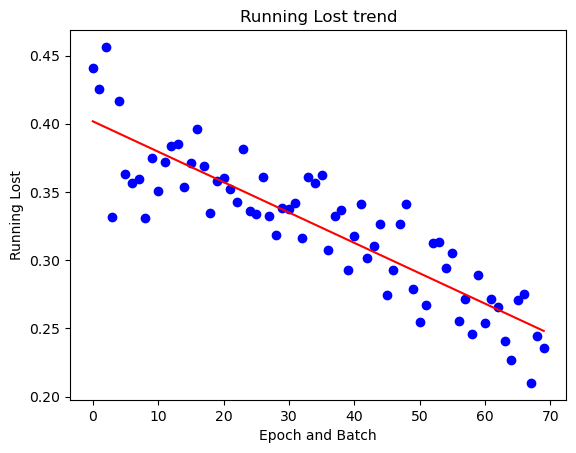

In [40]:
from scipy.stats import linregress # for line of best fit

# plot all loss
def plot_loss(all_lost):
    x = np.arange(len(all_lost))
    
    # create a scatter plot
    plt.scatter(x, all_lost, color='b')
    
    # create line of best fit
    slope, intercept, r_value, p_value, std_err = linregress(x, all_lost)
    y_pred = slope * x + intercept
    plt.plot(x, y_pred, label=f'Best-fit Line (y={slope:.2f}x+{intercept:.2f})', color='red')
    
    # add labels and title
    plt.xlabel('Epoch and Batch')
    plt.ylabel('Running Lost')
    plt.title('Running Lost trend')
    
    # display the plot
    plt.show()
plot_loss(all_lost)

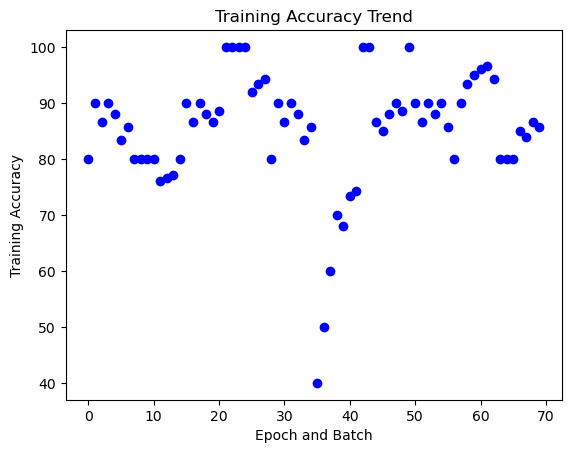

In [41]:
# Plot training accuracy
def plot_training_accuracy(all_accuracy):
    x = np.arange(len(all_accuracy))
    
    # create a scatter plot
    plt.scatter(x, all_accuracy, color='b')
    
    # add labels and title
    plt.xlabel('Epoch and Batch')
    plt.ylabel('Training Accuracy')
    plt.title('Training Accuracy Trend')
    
    # display the plot
    plt.show()
plot_training_accuracy(all_training_accuracy)

In [42]:
from pylab import *

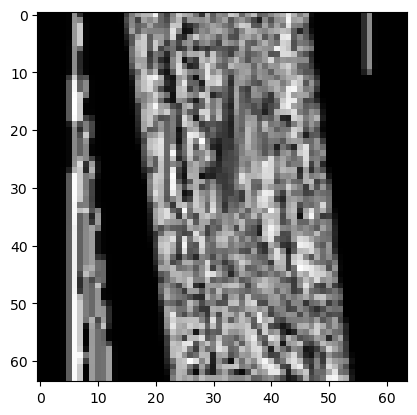

Ground Truth:  Negative


In [43]:
# Test the network on test data
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# Display the first image
# print(images[0].shape)
plt.imshow(images[0][0], cmap='gray')
plt.show()

classes = ['Negative', 'Postive'] # 0 is negative, 1 is positive
print('Ground Truth: ', classes[labels[2]])

In [44]:
net = Net()
net.load_state_dict(torch.load(ALL_PATH, weights_only=True))
outputs = net(images)
# print(outputs)

In [45]:
# Get prediction for first 4 images
_, predicted = torch.max(outputs, 1)
print(predicted)

print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

tensor([0, 1, 0, 1, 1])
GroundTruth:  Negative Postive Negative Postive
Predicted:  Negative Postive Negative Postive


In [46]:
# Test on whole dataset
def getAccuracy(net, valid_dataloader):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in valid_dataloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct, total

In [47]:
correct, total = getAccuracy(net, test_dataloader)
print(f'Accuracy of the network on the all test images: {100 * correct // total} %')

Accuracy of the network on the all test images: 48 %


### **Step 3.5: Calculate CNN metrics**
**Accuracy**: total correct percentage
$$accuracy=\frac{TP + TN}{TP+FP+FN+TN}$$
**Precision**: Only considers what was predicted as postive to see how many were actually positive
$$precision=\frac{TP}{TP+FP}$$
**Recall**: Only considers grouth truth postive to see how many were accurately predicted
$$recall=\frac{TP}{TP+FN}$$
**F**: Summary that combines both precision and recall
$$F=\frac{2*Precision*Recall}{Precision+Recall}$$

In [48]:
def get_class_metrics(test_net, valid_dataloader, model_name):
    classes = ['Negative', 'Positive']
    metrics = {classname: {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0} for classname in classes}

    # no gradients needed because we are not training
    with torch.no_grad():
        for data in valid_dataloader:
            images, labels = data
            outputs = test_net(images)
            _, predictions = torch.max(outputs, 1)
            # Update metrics for each prediction
            for label, prediction in zip(labels, predictions):
                for classname in classes:
                    class_idx = classes.index(classname)
                    if label == class_idx and prediction == class_idx:  # true Positive
                        metrics[classname]['TP'] += 1
                    elif label != class_idx and prediction == class_idx:  # false Positive
                        metrics[classname]['FP'] += 1
                    elif label == class_idx and prediction != class_idx:  # false Negative
                        metrics[classname]['FN'] += 1
                    elif label != class_idx and prediction != class_idx:  # true Negative
                        metrics[classname]['TN'] += 1
    
    # print metrics for each class
    for classname, counts in metrics.items():
        TP = counts['TP']
        FP = counts['FP']
        TN = counts['TN']
        FN = counts['FN']
        accuracy = (TP + TN) / (TP + FP + TN + FN) if (TP + FP + TN + FN) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        fScore = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        print(f"Class: {classname}")
        print(f"  TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")
        print(f"  Accuracy: {(accuracy * 100):.1f}%, Precision: {(precision*100):.1f}%, Recall: {(recall*100):.1f}%, F: {(fScore*100):.1f}%")

        add_eval_metrics(model_name + " " + classname, acc=accuracy, prec=precision, recall=recall, f1=fScore, sup0=None, sup1=None, focal=None)

In [49]:
get_class_metrics(net, test_dataloader, "all")

Class: Negative
  TP: 339, FP: 318, TN: 1212, FN: 1328
  Accuracy: 48.5%, Precision: 51.6%, Recall: 20.3%, F: 29.2%
Added all Negative evaluation metrics to eval_metrics.csv
Class: Positive
  TP: 1212, FP: 1328, TN: 339, FN: 318
  Accuracy: 48.5%, Precision: 47.7%, Recall: 79.2%, F: 59.6%
Added all Positive evaluation metrics to eval_metrics.csv


#### **Analysis**
- Really high training accuracy but low testing accuracy --> indicates overfitting

#### **Elbow Pytorch**

**Get Elbow Images**

In [50]:
def read_elbow_images(paths_df):
    filtered_df = paths_df[paths_df['image_path'].str.contains('/XR_ELBOW/')]
    
    elbow_images = []
    elbow_labels = []
    
    for path in filtered_df['image_path']:
        try:
            elbow_images.append(process_image(path))
            label = 1 if 'positive' in path else 0 
            elbow_labels.append(label)
        except FileNotFoundError:
            print(f"Image not found: {path}")
    
    return np.array(elbow_images), np.array(elbow_labels)

print("Reading training elbow images...")
elbow_train_img, elbow_train_labels = read_elbow_images(train_paths_df)
print(f"Loaded {elbow_train_img.shape[0]} images from XR_ELBOW category.")
print(f"Labels for XR_ELBOW length: {elbow_train_labels.shape[0]}")

print("Reading validation elbow images...")
elbow_valid_img, elbow_valid_labels = read_elbow_images(valid_paths_df)
print(f"Loaded {elbow_valid_img.shape[0]} images from XR_ELBOW category.")
print(f"Labels for XR_ELBOW length: {elbow_valid_labels.shape[0]}")

Reading training elbow images...
Loaded 4931 images from XR_ELBOW category.
Labels for XR_ELBOW length: 4931
Reading validation elbow images...
Loaded 465 images from XR_ELBOW category.
Labels for XR_ELBOW length: 465


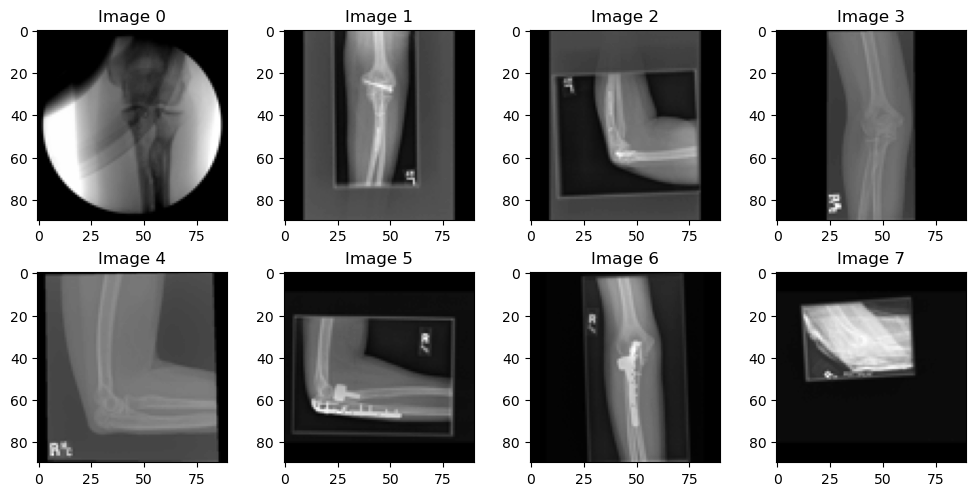

In [51]:
# Plot elbows
def plot_first_8(plot_img):
    plt.figure(figsize=(10, 5))
    for i in range(8):
        plt.subplot(2, 4, i + 1)  # 2x4 plot
        plt.imshow(plot_img[i], cmap='gray') 
        plt.title(f'Image {i}')
        # plt.axis('off')
    
    plt.tight_layout()
    plt.show()
plot_first_8(elbow_train_img)

In [52]:
#Convert to dataloader
elbow_train_dataset = XrayDataset(elbow_train_img, elbow_train_labels, transform=transform)
elbow_train_dataloader = DataLoader(elbow_train_dataset, batch_size=5, shuffle=True)

elbow_test_dataset = XrayDataset(elbow_valid_img, elbow_valid_labels, transform=transform)
elbow_test_dataloader = DataLoader(elbow_test_dataset, batch_size=5, shuffle=True)

**Train on just elbow images**

Finished Training 0.296


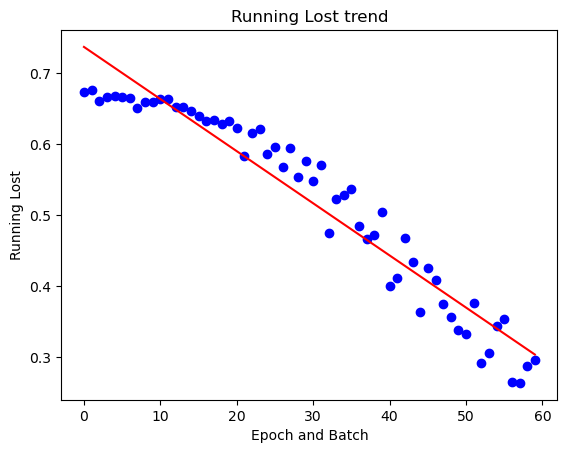

final train accuracy: 70.0


In [53]:
ELBOW_PATH = './elbow_net.pth'
elbow_net = Net()
elbow_lost, elbow_train_accuracy = train_network(elbow_net, elbow_train_dataloader, ELBOW_PATH, 200)
plot_loss(elbow_lost)
print("final train accuracy:", elbow_train_accuracy[-1])

In [54]:
# Test
elbow_net = Net()
elbow_net.load_state_dict(torch.load(ELBOW_PATH, weights_only=True))

<All keys matched successfully>

In [55]:
correct, total = getAccuracy(elbow_net, elbow_test_dataloader)
elbow_accuracy = correct / total
print(f'Accuracy of the network on the all test images: {(100 * elbow_accuracy):.2f} %')
get_class_metrics(elbow_net, elbow_test_dataloader, "Elbow")

Accuracy of the network on the all test images: 58.49 %
Class: Negative
  TP: 169, FP: 127, TN: 103, FN: 66
  Accuracy: 58.5%, Precision: 57.1%, Recall: 71.9%, F: 63.7%
Added Elbow Negative evaluation metrics to eval_metrics.csv
Class: Positive
  TP: 103, FP: 66, TN: 169, FN: 127
  Accuracy: 58.5%, Precision: 60.9%, Recall: 44.8%, F: 51.6%
Added Elbow Positive evaluation metrics to eval_metrics.csv


**Use Data Augmentation to increase number of training images**
- To do this, we will flip images along the y axis and rotate images 30 and 15 degrees in both directions

In [56]:
# Get current number of 0 and 1 in train dataset 
# to make sure dataset is balanced
count_neg = np.sum(elbow_train_labels == 0)
count_pos = np.sum(elbow_train_labels == 1)
print("Number of Negative:", count_neg)
print("Number of Positive:", count_pos)

Number of Negative: 2925
Number of Positive: 2006


In [57]:
def createAugmentedImages(originalImg):
    augmented_images = []
    augmentation_functions = [
        [data_aug_flip_y],
        [data_aug_rotate_neg30],
        [data_aug_rotate_neg15],
        [data_aug_rotate_pos30],
        [data_aug_rotate_pos15],
        [data_aug_flip_y, data_aug_rotate_neg15],
        [data_aug_flip_y, data_aug_rotate_pos15],
        [data_aug_flip_y, data_aug_rotate_neg30],
        [data_aug_flip_y, data_aug_rotate_pos30],
    ]

    for cur_img in originalImg: 
        augmented_images.append(np.expand_dims(cur_img, axis=0)) # keep original image
        
        # apply each augmentation function and store the result
        for aug_funcs in augmentation_functions:
            augmented_image = preprocess_copy(aug_funcs, cur_img)
            augmented_images.append(np.expand_dims(augmented_image, axis=0))
    return np.concatenate(augmented_images, axis=0) # convert to np array

In [58]:
# Create neg images
neg_indexes = np.where(elbow_train_labels == 0)[0]
neg_images = elbow_train_img[neg_indexes]
print(neg_images.shape)
new_neg_img = createAugmentedImages(neg_images)
print(new_neg_img.shape)

(2925, 90, 90)
(29250, 90, 90)


In [59]:
# Create pos images
pos_indexes = np.where(elbow_train_labels == 1)[0]
pos_images = elbow_train_img[pos_indexes]
print(pos_images.shape)
new_pos_img = createAugmentedImages(pos_images)
print(new_pos_img.shape)

(2006, 90, 90)
(20060, 90, 90)


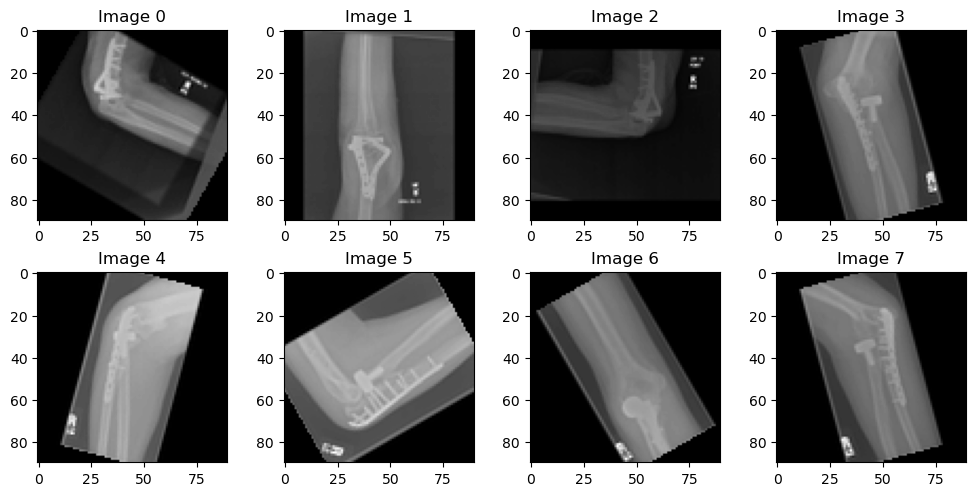

In [60]:
import random

# Perform data augmentation on validation images for consistency
def randomize_data_augmentation(images):
    for i in range(len(images)):
        #Randomize what is performed
        random_number = random.randint(0, 10)
        if random_number == 0:
            images[i] = preprocess([data_aug_flip_x], images[i]) # directly edit image (so there aren't more images)
        elif random_number == 1:
            images[i] = preprocess([data_aug_flip_y], images[i])
        elif random_number == 2:
            images[i] = preprocess([data_aug_rotate_neg30], images[i])
        elif random_number == 3:
            images[i] = preprocess([data_aug_rotate_neg15], images[i])
        elif random_number == 4:
            images[i] = preprocess([data_aug_rotate_pos30], images[i])
        elif random_number == 5:
            images[i] = preprocess([data_aug_rotate_pos15], images[i])
        elif random_number == 6:
            images[i] = preprocess([data_aug_flip_y, data_aug_rotate_neg30], images[i])
        elif random_number == 7:
            images[i] = preprocess([data_aug_flip_y, data_aug_rotate_neg15], images[i])
        elif random_number == 8:
            images[i] = preprocess([data_aug_flip_y, data_aug_rotate_pos30], images[i])
        elif random_number == 9:
            images[i] = preprocess([data_aug_flip_y, data_aug_rotate_pos15], images[i])

randomize_data_augmentation(elbow_valid_img)

# display first 8 validation images
plot_first_8(elbow_valid_img)

In [61]:
# Combine and shuffle pos and neg images
neg_labels = np.zeros(len(new_neg_img), dtype=int)
pos_labels = np.ones(len(new_pos_img), dtype=int)

augmented_elbow_train_images = np.concatenate((new_neg_img, new_pos_img), axis=0)
augmented_elbow_train_labels = np.concatenate((neg_labels, pos_labels), axis=0)

# Shuffle the combined images and labels together
indices = np.random.permutation(len(augmented_elbow_train_images))
augmented_elbow_train_images = augmented_elbow_train_images[indices] #apply permutation
augmented_elbow_train_labels = augmented_elbow_train_labels[indices]

Finished Training0.556


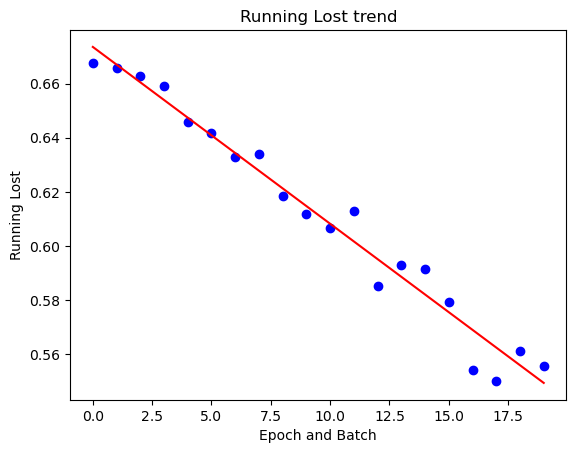

Final Train Accuracy: 75.0


In [62]:
# Train
# Transformer to dataloader
elbow_augmented_train_dataset = XrayDataset(augmented_elbow_train_images, augmented_elbow_train_labels, transform=transform)
elbow_augmented_train_dataloader = DataLoader(elbow_augmented_train_dataset, batch_size=5, shuffle=True)
elbow_augmented_valid_dataset = XrayDataset(elbow_valid_img, augmented_elbow_train_labels, transform=transform)
elbow_augmented_valid_dataloader = DataLoader(elbow_augmented_valid_dataset, batch_size=5, shuffle=True)

# Train network
ELBOW_AUGMENTED_PATH = './elbow_augmented_net.pth'
elbow_augmented_net = Net()
elbow_augmented_lost, elbow_augmented_train_accuracy = train_network(elbow_augmented_net, elbow_augmented_train_dataloader, ELBOW_AUGMENTED_PATH, 2000, epochs=5)
plot_loss(elbow_augmented_lost)
print("Final Train Accuracy:", elbow_augmented_train_accuracy[-1])

In [63]:
# Test
elbow_augmented_net = Net()
elbow_augmented_net.load_state_dict(torch.load(ELBOW_AUGMENTED_PATH, weights_only=True))

# Print results
correct, total = getAccuracy(elbow_augmented_net, elbow_augmented_valid_dataloader)
augmented_accuracy = correct / total
print(f'Accuracy of the network on the all augmented images: {(100 * augmented_accuracy):.2f} %')
get_class_metrics(elbow_augmented_net, elbow_augmented_valid_dataloader, "Elbow Augmented")

Accuracy of the network on the all augmented images: 47.96 %
Class: Negative
  TP: 158, FP: 131, TN: 65, FN: 111
  Accuracy: 48.0%, Precision: 54.7%, Recall: 58.7%, F: 56.6%
Added Elbow Augmented Negative evaluation metrics to eval_metrics.csv
Class: Positive
  TP: 65, FP: 111, TN: 158, FN: 131
  Accuracy: 48.0%, Precision: 36.9%, Recall: 33.2%, F: 34.9%
Added Elbow Augmented Positive evaluation metrics to eval_metrics.csv


**Perform Preprocessing on elbow images**

In [64]:
print(elbow_train_img.shape)

(4931, 90, 90)


In [65]:
func_list = [filter_grayscale, filter_unsharp, filter_laplacian]

# apply preprocessing methods to training
print("Copying images")
elbow_train_images_ppr = elbow_train_img.copy()
print("Preprocessing images")
for i in range(len(elbow_train_images_ppr)):
    elbow_train_images_ppr[i] = preprocess(func_list, elbow_train_images_ppr[i])
print("train_images shape:", elbow_train_images_ppr.shape)

# apply preprocessing methods to validation
print("Copying images")
elbow_valid_images_ppr = elbow_valid_img.copy()
print("Preprocessing images")
for i in range(len(elbow_valid_images_ppr)):
    elbow_valid_images_ppr[i] = preprocess(func_list, elbow_valid_images_ppr[i])
print("valid_images shape:", elbow_valid_images_ppr.shape)

Copying images
Preprocessing images
train_images shape: (4931, 90, 90)
Copying images
Preprocessing images
valid_images shape: (465, 90, 90)


In [66]:
#Convert to dataloader
elbow_preprocess_train_dataset = XrayDataset(elbow_train_images_ppr, elbow_train_labels, transform=transform)
elbow_preprocess_train_dataloader = DataLoader(elbow_preprocess_train_dataset, batch_size=5, shuffle=True)

elbow_preprocess_test_dataset = XrayDataset(elbow_valid_images_ppr, elbow_valid_labels, transform=transform)
elbow_preprocess_test_dataloader = DataLoader(elbow_preprocess_test_dataset, batch_size=5, shuffle=True)

Finished Training0.635


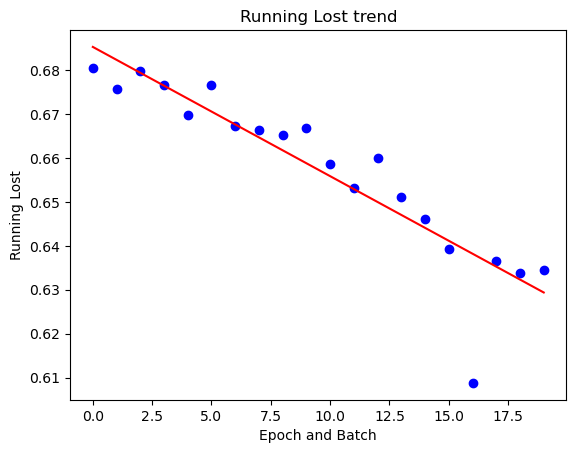

Final Train Accuracy: 70.0


In [67]:
# Train network
ELBOW_PREPROCESS_PATH = './elbow_preprocess_net.pth'
elbow_preprocess_net = Net()
elbow_preprocess_lost, elbow_preprocess_train_accuracy = train_network(elbow_preprocess_net, elbow_preprocess_train_dataloader, ELBOW_PREPROCESS_PATH, epochs=5)
plot_loss(elbow_preprocess_lost)
print("Final Train Accuracy:", elbow_preprocess_train_accuracy[-1])

In [ ]:
# Test network
elbow_preprocess_net = Net()
elbow_preprocess_net.load_state_dict(torch.load(ELBOW_PREPROCESS_PATH, weights_only=True))
outputs = elbow_preprocess_net(images)

# Print results
correct, total = getAccuracy(elbow_preprocess_net, elbow_preprocess_test_dataloader)
preprocess_accuracy = correct / total
print(f'Accuracy of the network on the all preprocess test images: {(100 * preprocess_accuracy):.2f} %')
get_class_metrics(elbow_preprocess_net, elbow_preprocess_test_dataloader, "Elbow Unsharp + Laplacian")

Accuracy of the network on the all preprocess test images: 52.69 %
Class: Negative
  TP: 221, FP: 206, TN: 24, FN: 14
  Accuracy: 52.7%, Precision: 51.8%, Recall: 94.0%, F: 66.8%
Added Elbow Unsharp + Laplacian Negative evaluation metrics to eval_metrics.csv
Class: Positive
  TP: 24, FP: 14, TN: 221, FN: 206
  Accuracy: 52.7%, Precision: 63.2%, Recall: 10.4%, F: 17.9%
Added Elbow Unsharp + Laplacian Positive evaluation metrics to eval_metrics.csv


**Try filter_unsharp only**

Copying images
Preprocessing images
train_images shape: (4931, 90, 90)
Copying images
Preprocessing images
valid_images shape: (465, 90, 90)


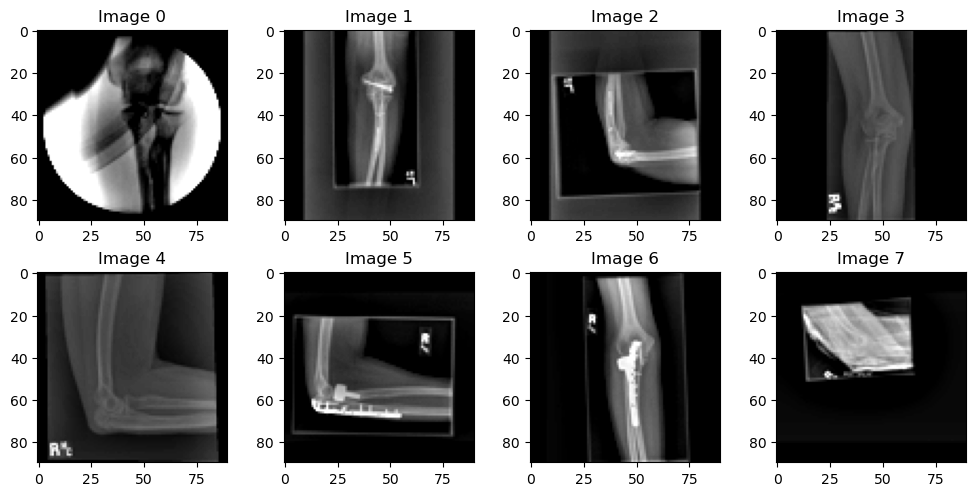

In [69]:
def apply_preprocess (train_img, valid_img, func_list):
    print("Copying images")
    train_images_ppr = train_img.copy()
    print("Preprocessing images")
    for i in range(len(train_images_ppr)):
        train_images_ppr[i] = preprocess(func_list, train_images_ppr[i])
    print("train_images shape:", train_images_ppr.shape)
    
    # apply preprocessing methods to validation
    print("Copying images")
    valid_images_ppr = valid_img.copy()
    print("Preprocessing images")
    for i in range(len(valid_images_ppr)):
        valid_images_ppr[i] = preprocess(func_list, valid_images_ppr[i])
    print("valid_images shape:", valid_images_ppr.shape)

    # return 
    return train_images_ppr, valid_images_ppr

unsharp_train_img, unsharp_valid_img = apply_preprocess(elbow_train_img, elbow_valid_img, [filter_unsharp])

# plot images
plot_first_8(unsharp_train_img)

In [70]:
#Convert to dataloader
elbow_unsharp_train_dataset = XrayDataset(unsharp_train_img, elbow_train_labels, transform=transform)
elbow_unsharp_train_dataloader = DataLoader(elbow_unsharp_train_dataset, batch_size=5, shuffle=True)

elbow_unsharp_test_dataset = XrayDataset(elbow_valid_img, elbow_valid_labels, transform=transform)
elbow_unsharp_test_dataloader = DataLoader(elbow_unsharp_test_dataset, batch_size=5, shuffle=True)

Finished Training0.574


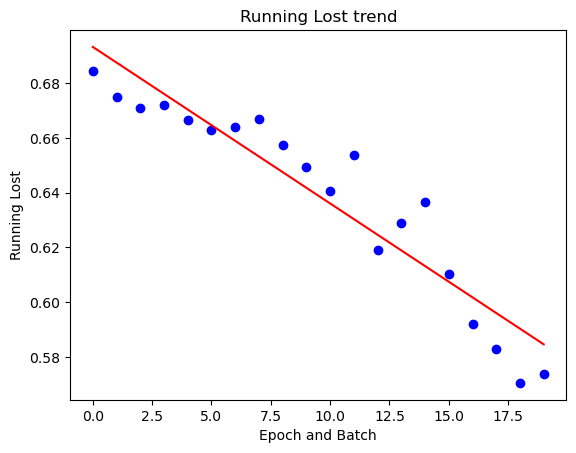

Final Train Accuracy: 70.0


In [71]:
# Train network
ELBOW_UNSHARP_PATH = './elbow_unsharp_net.pth'
elbow_unsharp_net = Net()
elbow_unsharp_lost, elbow_unsharp_train_accuracy = train_network(elbow_unsharp_net, elbow_unsharp_train_dataloader, ELBOW_UNSHARP_PATH, epochs=5)
plot_loss(elbow_unsharp_lost)
print("Final Train Accuracy:", elbow_unsharp_train_accuracy[-1])

In [ ]:
# Test network
elbow_unsharp_net = Net()
elbow_unsharp_net.load_state_dict(torch.load(ELBOW_UNSHARP_PATH, weights_only=True))

# Print results
correct, total = getAccuracy(elbow_unsharp_net, elbow_unsharp_test_dataloader)
unsharp_accuracy = correct / total
print(f'Accuracy of the network on the all unsharp preprocess test images: {(100 * unsharp_accuracy):.2f} %')
get_class_metrics(elbow_unsharp_net, elbow_unsharp_test_dataloader, "Unsharp")

Accuracy of the network on the all unsharp preprocess test images: 48.17 %
Class: Negative
  TP: 197, FP: 203, TN: 27, FN: 38
  Accuracy: 48.2%, Precision: 49.2%, Recall: 83.8%, F: 62.0%
Added Unsharp Negative evaluation metrics to eval_metrics.csv
Class: Positive
  TP: 27, FP: 38, TN: 197, FN: 203
  Accuracy: 48.2%, Precision: 41.5%, Recall: 11.7%, F: 18.3%
Added Unsharp Positive evaluation metrics to eval_metrics.csv


**Simplify CNN to prevent overfitting**

In [73]:
# Define simpler Net
class Simple_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3) # 3x3 kernel instead of 5x2, just 1 conv layer
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(6 * 31 * 31, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Finished Training 0.623


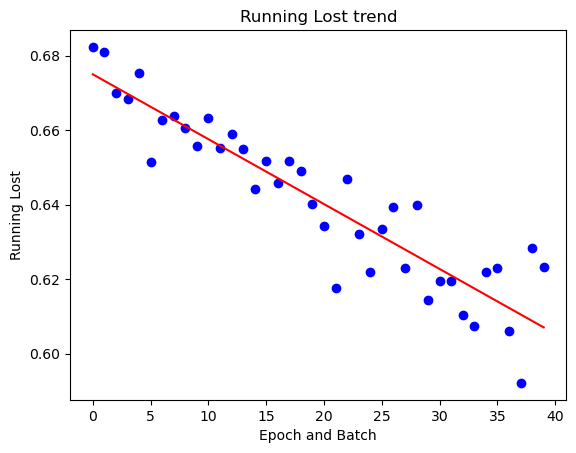

final train accuracy: 60.0


In [74]:
ELBOW_SIMPLE_NET_PATH = './elbow_simple_net.pth'
elbow_simple_net = Simple_Net()
elbow_simple_lost, elbow_simple_train_accuracy = train_network(elbow_simple_net, elbow_train_dataloader, ELBOW_SIMPLE_NET_PATH, epochs=10)
plot_loss(elbow_simple_lost)
print("final train accuracy:", elbow_simple_train_accuracy[-1])

In [75]:
# Test
elbow_simple_net = Simple_Net()
elbow_simple_net.load_state_dict(torch.load(ELBOW_SIMPLE_NET_PATH, weights_only=True), strict=False)
correct, total = getAccuracy(elbow_simple_net, elbow_test_dataloader)
simple_accuracy = correct / total
print(f'Accuracy of the network on the all preprocess test images: {(100 * simple_accuracy):.2f} %')
get_class_metrics(elbow_simple_net, elbow_test_dataloader, "Elbow Simple Net")

Accuracy of the network on the all preprocess test images: 52.90 %
Class: Negative
  TP: 227, FP: 211, TN: 19, FN: 8
  Accuracy: 52.9%, Precision: 51.8%, Recall: 96.6%, F: 67.5%
Added Elbow Simple Net Negative evaluation metrics to eval_metrics.csv
Class: Positive
  TP: 19, FP: 8, TN: 227, FN: 211
  Accuracy: 52.9%, Precision: 70.4%, Recall: 8.3%, F: 14.8%
Added Elbow Simple Net Positive evaluation metrics to eval_metrics.csv


**Decrease Epoch Number to Avoid Overfitting**

Finished Training0.637


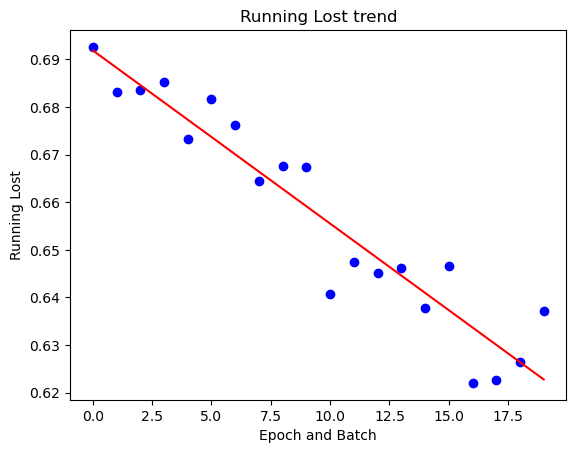

final train accuracy: 50.0


In [76]:
ELBOW_SIMPLE_NET_PATH_2 = './elbow_simple_net.pth'
elbow_simple_net_2 = Simple_Net()
elbow_simple_lost_2, elbow_simple_train_accuracy_2 = train_network(elbow_simple_net_2, elbow_train_dataloader, ELBOW_SIMPLE_NET_PATH, epochs=5)
plot_loss(elbow_simple_lost_2)
print("final train accuracy:", elbow_simple_train_accuracy_2[-1])

In [77]:
# Test
elbow_simple_net_2 = Simple_Net()
elbow_simple_net_2.load_state_dict(torch.load(ELBOW_SIMPLE_NET_PATH_2, weights_only=True), strict=False)
outputs = elbow_simple_net_2(images)

correct, total = getAccuracy(elbow_simple_net_2, elbow_test_dataloader)
accuracy = correct / total
print(f'Accuracy of the network on the all preprocess test images: {(100 * accuracy):.2f} %')
get_class_metrics(elbow_simple_net_2, elbow_test_dataloader, "Elbow Simple Fewer Epochs")

Accuracy of the network on the all preprocess test images: 53.76 %
Class: Negative
  TP: 220, FP: 200, TN: 30, FN: 15
  Accuracy: 53.8%, Precision: 52.4%, Recall: 93.6%, F: 67.2%
Added Elbow Simple Fewer Epochs Negative evaluation metrics to eval_metrics.csv
Class: Positive
  TP: 30, FP: 15, TN: 220, FN: 200
  Accuracy: 53.8%, Precision: 66.7%, Recall: 13.0%, F: 21.8%
Added Elbow Simple Fewer Epochs Positive evaluation metrics to eval_metrics.csv


**Add Dropout and Layer Normalization**

In [78]:
import torch.nn.functional as F
import torch
import torch.nn as nn

class Regularized_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3) 
        self.pool = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(6 * 31 * 31, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2) 

        # Dropout layers
        self.dropout1 = nn.Dropout(0.5)  # 50% probability
        self.dropout2 = nn.Dropout(0.5)

        # Layer Normalization layers
        self.layer_norm1 = nn.LayerNorm(120)
        self.layer_norm2 = nn.LayerNorm(84)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.layer_norm1(x) # apply Layer Normalization
        x = self.dropout1(x) # apply Dropout
        
        x = F.relu(self.fc2(x))
        x = self.layer_norm2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        return x

Finished Training0.663


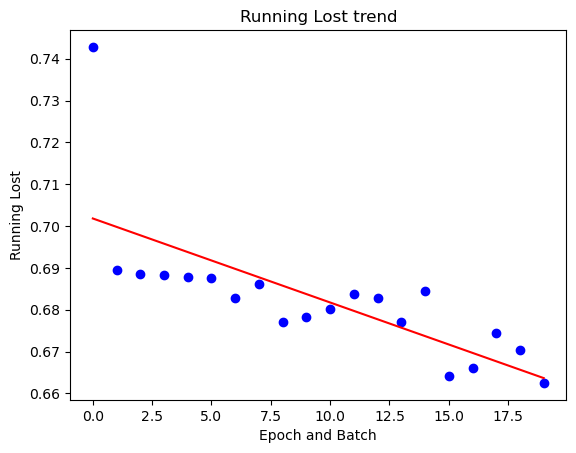

final train accuracy: 75.0


In [79]:
ELBOW_REG_NET_PATH = './elbow_reg_net.pth'
elbow_reg_net = Regularized_Net()
elbow_reg_lost, elbow_reg_train_accuracy = train_network(elbow_reg_net, elbow_train_dataloader, ELBOW_REG_NET_PATH, 200, epochs=5)
plot_loss(elbow_reg_lost)
print("final train accuracy:", elbow_reg_train_accuracy[-1])

In [80]:
# Test
elbow_reg_net = Regularized_Net()
elbow_reg_net.load_state_dict(torch.load(ELBOW_REG_NET_PATH, weights_only=True))

correct, total = getAccuracy(elbow_reg_net, elbow_test_dataloader)
reg_accuracy = correct / total
print(f'Accuracy of the network on the all preprocess test images: {(100 * reg_accuracy):.2f} %')
get_class_metrics(elbow_reg_net, elbow_test_dataloader, "Elbow Regularized Net")

Accuracy of the network on the all preprocess test images: 51.61 %
Class: Negative
  TP: 225, FP: 208, TN: 22, FN: 10
  Accuracy: 53.1%, Precision: 52.0%, Recall: 95.7%, F: 67.4%
Added Elbow Regularized Net Negative evaluation metrics to eval_metrics.csv
Class: Positive
  TP: 22, FP: 10, TN: 225, FN: 208
  Accuracy: 53.1%, Precision: 68.8%, Recall: 9.6%, F: 16.8%
Added Elbow Regularized Net Positive evaluation metrics to eval_metrics.csv


**Test on Wrist Dataset instead of Elbow (More Images)**

In [81]:
# See which category has the most training images
import pandas as pd

CATEGORIES = ['XR_SHOULDER', 'XR_WRIST', 'XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS']
category_counts = {category: 0 for category in CATEGORIES}
for category in CATEGORIES:
    category_counts[category] = train_paths_df['image_path'].str.contains(category).sum()

most_common_category = max(category_counts, key=category_counts.get)
most_common_count = category_counts[most_common_category]

print(f"Elbow has {category_counts['XR_ELBOW']} images")
print(f"The most common category is '{most_common_category}' with {most_common_count} images.")

Elbow has 4931 images
The most common category is 'XR_WRIST' with 9752 images.


In [82]:
def read_wrist_images(paths_df):
    filtered_df = paths_df[paths_df['image_path'].str.contains('/XR_WRIST/')]
    
    wrist_images = []
    wrist_labels = []
    
    for path in filtered_df['image_path']:
        try:
            wrist_images.append(process_image(path))
            label = 1 if 'positive' in path else 0 
            wrist_labels.append(label)
        except FileNotFoundError:
            print(f"Image not found: {path}")
    
    return np.array(wrist_images), np.array(wrist_labels)

print("Reading training wrist images...")
wrist_train_img, wrist_train_labels = read_wrist_images(train_paths_df)
print(f"Loaded {wrist_train_img.shape[0]} images.")
print(f"Labels shape: {wrist_train_labels.shape}")

print("Reading validation wrist images...")
wrist_valid_img, wrist_valid_labels = read_wrist_images(valid_paths_df)
print(f"Loaded {wrist_valid_img.shape[0]} images.")
print(f"Labels shape: {wrist_valid_labels.shape}")

Reading training wrist images...
Loaded 9752 images.
Labels shape: (9752,)
Reading validation wrist images...
Loaded 659 images.
Labels shape: (659,)


Wrist Training Images


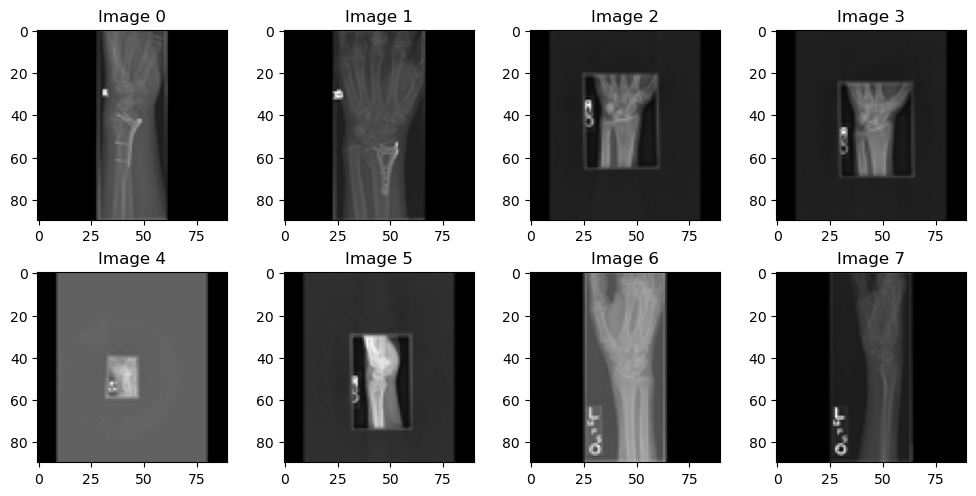

Wrist Testing Images


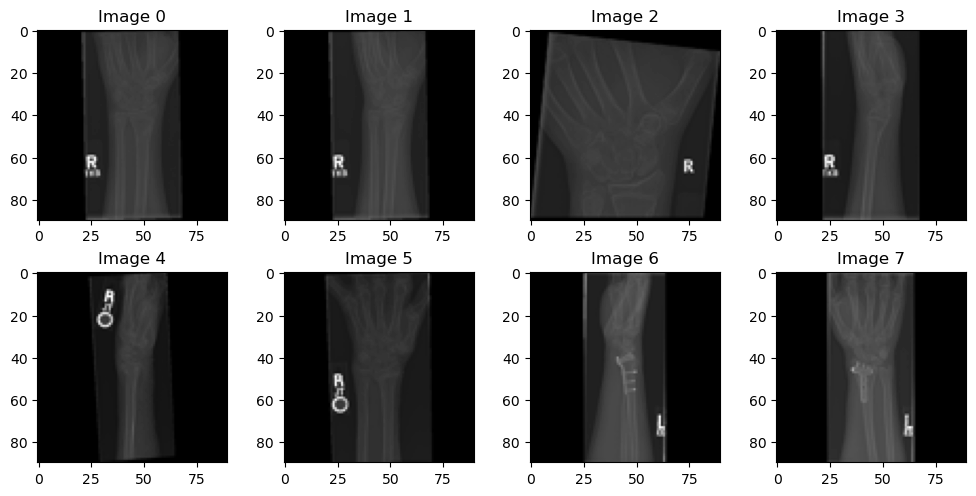

In [83]:
print("Wrist Training Images")
plot_first_8(wrist_train_img)
print("Wrist Testing Images")
plot_first_8(wrist_valid_img)

In [84]:
# Make Wrist dataloader
wrist_train_dataset = XrayDataset(wrist_train_img, wrist_train_labels, transform=transform)
wrist_train_dataloader = DataLoader(wrist_train_dataset, batch_size=5, shuffle=True)
wrist_test_dataset = XrayDataset(wrist_valid_img, wrist_valid_labels, transform=transform)
wrist_test_dataloader = DataLoader(wrist_test_dataset, batch_size=5, shuffle=True)

Finished Training0.603


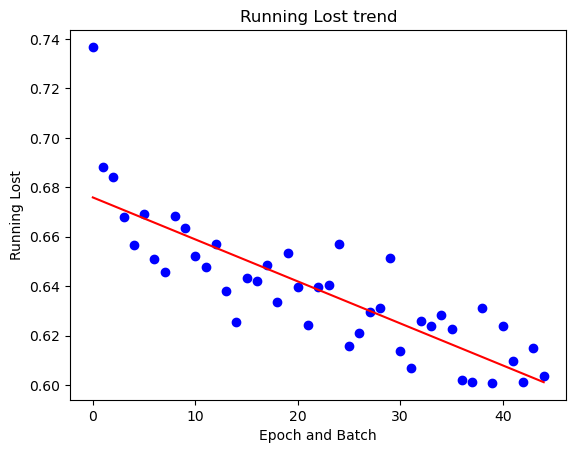

final train accuracy: 64.44


In [85]:
# Train on wrist images using reg net
WRIST_REG_NET_PATH = './wrist_reg_net.pth'
wrist_reg_net = Regularized_Net()
wrist_reg_lost, wrist_reg_train_accuracy = train_network(wrist_reg_net, wrist_train_dataloader, WRIST_REG_NET_PATH, 200, epochs=5)
plot_loss(wrist_reg_lost)
print("final train accuracy:", wrist_reg_train_accuracy[-1].round(2))

In [86]:
# Test
wrist_reg_net = Regularized_Net()
wrist_reg_net.load_state_dict(torch.load(WRIST_REG_NET_PATH, weights_only=True))
# outputs = wrist_reg_net(images)

correct, total = getAccuracy(wrist_reg_net, elbow_test_dataloader)
accuracy = correct / total
print(f'Accuracy of the network on the all wrist test images: {(100 * accuracy):.2f} %')
get_class_metrics(wrist_reg_net, wrist_test_dataloader, "Wrist Regularized Net")

Accuracy of the network on the all wrist test images: 56.34 %
Class: Negative
  TP: 288, FP: 152, TN: 143, FN: 76
  Accuracy: 65.4%, Precision: 65.5%, Recall: 79.1%, F: 71.6%
Added Wrist Regularized Net Negative evaluation metrics to eval_metrics.csv
Class: Positive
  TP: 143, FP: 76, TN: 288, FN: 152
  Accuracy: 65.4%, Precision: 65.3%, Recall: 48.5%, F: 55.6%
Added Wrist Regularized Net Positive evaluation metrics to eval_metrics.csv


**Larger Model for full image**

In [87]:
# Define CNN
class Large_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 5) # 3rd layer
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32 * 60 * 60, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x))) 
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Reading training elbow images...
Loaded 4931 images from XR_ELBOW category.
Labels for XR_ELBOW length: 4931
Reading validation elbow images...
Loaded 465 images from XR_ELBOW category.
Labels for XR_ELBOW length: 465


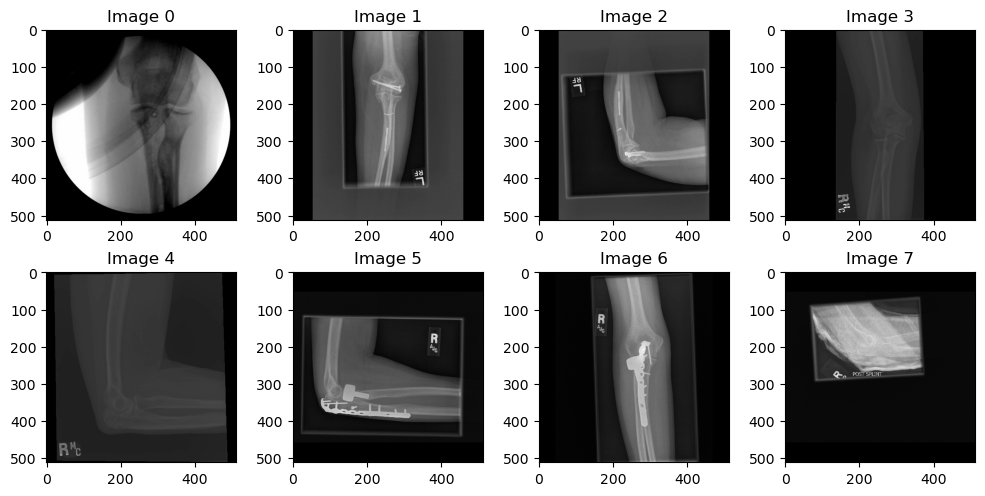

In [88]:
# Read Elbow images (without any resize)
def process_image_no_resize(image_path):
    image = Image.open(image_path) # read image

    # Add padding to image
    original_width, original_height = image.size
    new_image = Image.new('L', (TARGET_SIZE, TARGET_SIZE), 0)  # black background of target size
    paste_x = (TARGET_SIZE - original_width) // 2
    paste_y = (TARGET_SIZE - original_height) // 2
    new_image.paste(image, (paste_x, paste_y))
    
    return np.array(new_image)
    
def read_elbow_images_no_resize(paths_df):
    filtered_df = paths_df[paths_df['image_path'].str.contains('/XR_ELBOW/')]
    
    elbow_images = []
    elbow_labels = []
    
    for path in filtered_df['image_path']:
        try:
            elbow_images.append(process_image_no_resize(path))
            label = 1 if 'positive' in path else 0 
            elbow_labels.append(label)
        except FileNotFoundError:
            print(f"Image not found: {path}")
    
    return np.array(elbow_images), np.array(elbow_labels)

print("Reading training elbow images...")
elbow_train_full_img, elbow_train_full_labels = read_elbow_images_no_resize(train_paths_df)
print(f"Loaded {elbow_train_full_img.shape[0]} images from XR_ELBOW category.")
print(f"Labels for XR_ELBOW length: {elbow_train_full_labels.shape[0]}")

print("Reading validation elbow images...")
elbow_valid_full_img, elbow_valid_full_labels = read_elbow_images_no_resize(valid_paths_df)
print(f"Loaded {elbow_valid_full_img.shape[0]} images from XR_ELBOW category.")
print(f"Labels for XR_ELBOW length: {elbow_valid_full_labels.shape[0]}")

plot_first_8(elbow_train_full_img)

In [89]:
# Load into dataloader with no resize
PYTORCH_FULL_SIZE = TARGET_SIZE # 512
full_transform = transforms.Compose([
    transforms.Resize((PYTORCH_FULL_SIZE, PYTORCH_FULL_SIZE)),
    transforms.ToTensor()
])

# Create dataset and dataloader
full_train_dataset = XrayDataset(elbow_train_full_img, elbow_train_full_labels, transform=full_transform)
full_train_dataloader = DataLoader(full_train_dataset, batch_size=5, shuffle=True)

full_test_dataset = XrayDataset(elbow_valid_full_img, elbow_valid_full_labels, transform=full_transform)
full_test_dataloader = DataLoader(full_test_dataset, batch_size=5, shuffle=True)

Finished Training0.605


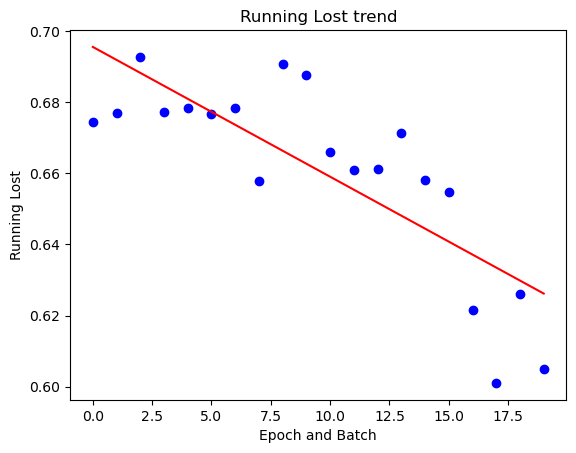

final train accuracy: 55.0


In [90]:
# Train (slower because of the larger images)
ELBOW_FULL_NET_PATH = './elbow_full_net.pth'
full_net = Large_Net()
full_net_lost, full_net_accuracy = train_network(full_net, full_train_dataloader, ELBOW_FULL_NET_PATH, 200, epochs=5)
plot_loss(full_net_lost)
print("final train accuracy:", full_net_accuracy[-1].round(2))

In [91]:
# Test
full_net = Large_Net()
full_net.load_state_dict(torch.load(ELBOW_FULL_NET_PATH, weights_only=True))

correct, total = getAccuracy(full_net, full_test_dataloader)
full_accuracy = correct / total
print(f'Accuracy of the network on the full (no resize) elbow images: {(100 * full_accuracy):.2f} %')
get_class_metrics(full_net, full_test_dataloader, "Full Elbow")

Accuracy of the network on the full (no resize) elbow images: 52.69 %
Class: Negative
  TP: 202, FP: 187, TN: 43, FN: 33
  Accuracy: 52.7%, Precision: 51.9%, Recall: 86.0%, F: 64.7%
Added Full Elbow Negative evaluation metrics to eval_metrics.csv
Class: Positive
  TP: 43, FP: 33, TN: 202, FN: 187
  Accuracy: 52.7%, Precision: 56.6%, Recall: 18.7%, F: 28.1%
Added Full Elbow Positive evaluation metrics to eval_metrics.csv


## <ins>**Step 4: Visualize Results</ins>**
Plot Training vs Testing Accuracy for elbow images

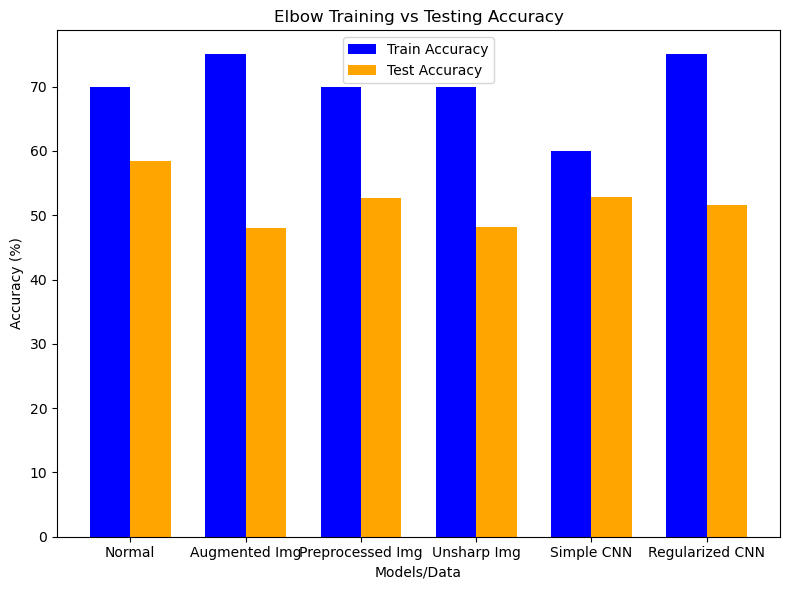

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# Get Accuracies
train_accuracies = [elbow_train_accuracy[-1], elbow_augmented_train_accuracy[-1], elbow_preprocess_train_accuracy[-1], elbow_unsharp_train_accuracy
[-1], elbow_simple_train_accuracy[-1], elbow_reg_train_accuracy[-1]]
test_accuracies = [elbow_accuracy, augmented_accuracy, preprocess_accuracy, unsharp_accuracy, simple_accuracy, reg_accuracy]
test_accuracies = [x * 100 for x in test_accuracies] # to convert to percent
categories = ['Normal', 'Augmented Img', 'Preprocessed Img', 'Unsharp Img', 'Simple CNN', 'Regularized CNN']

fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.35
index = np.arange(len(categories)) 

# Plot bars
ax.bar(index, train_accuracies, bar_width, label='Train Accuracy', color='blue')
ax.bar(index + bar_width, test_accuracies, bar_width, label='Test Accuracy', color='orange')

ax.set_xlabel('Models/Data')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Elbow Training vs Testing Accuracy')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories)
ax.legend()

plt.tight_layout()
plt.show()

**Create Heatmap of Evaluation Metrics**

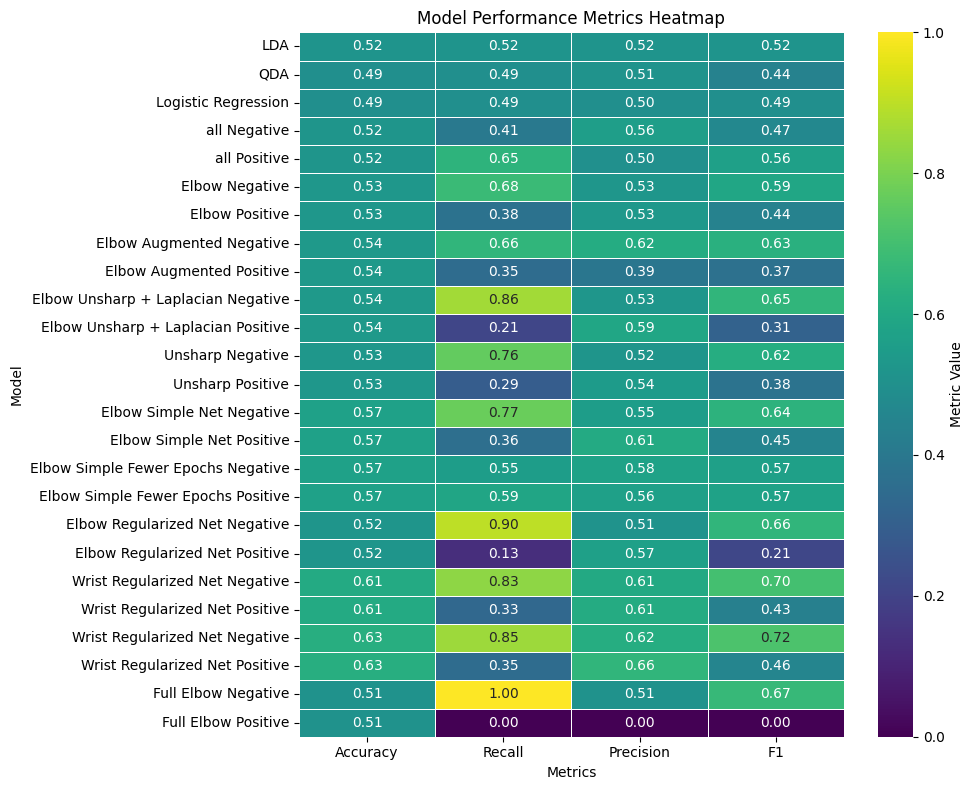

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('eval_metrics.csv')
heatmap_data = data[['ML Model', 'Accuracy', 'Recall', 'Precision', 'F1']]

# Set the model names as the index
heatmap_data.set_index('ML Model', inplace=True)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".2f", 
    cmap="viridis",
    linewidths=0.5,
    cbar_kws={'label': 'Metric Value'}
)

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Model')
plt.title('Model Performance Metrics Heatmap')

# Display the heatmap
plt.tight_layout()
plt.show()